In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [166]:
plt.rcParams["figure.figsize"] = (15,8) #set size of plot
plt.rcParams.update({'font.size': 22})

In [167]:
os.chdir('/home/MA')

For Switzerland, a weather station near Zurich airport was chosen (LSZH)

In [168]:
HDD_CH = pd.read_csv('Data/LSZH_HDD_12C.csv')

For Spain, LEZL station near Sevilla was selected

In [169]:
HDD_Spain = pd.read_csv('Data/LEZL_HDD_12C.csv')

In [170]:
load_CH = pd.read_pickle('Calculations/CH/load_CH_separated.pkl')

Goal: to recreate a heating demand profile for Spain based on the one provided for Switzerland.
Approach: Divide all heating energy by total of heating degree days for Switzerland, then multiply Spain's heating degree days. Same approach for cooling demand.


Calculations were carried out with base temperature of 12° Celsius for heating and 25° Celsius for cooling, which is a valid assumption based on https://www.sciencedirect.com/science/article/pii/S2352710218301086#:~:text=The%20air%20temperature%20is%20defined,the%20basis%20for%20climate%20classification.
Source for heating and cooling days : https://www.degreedays.net/#

## First, let's deal with heating:

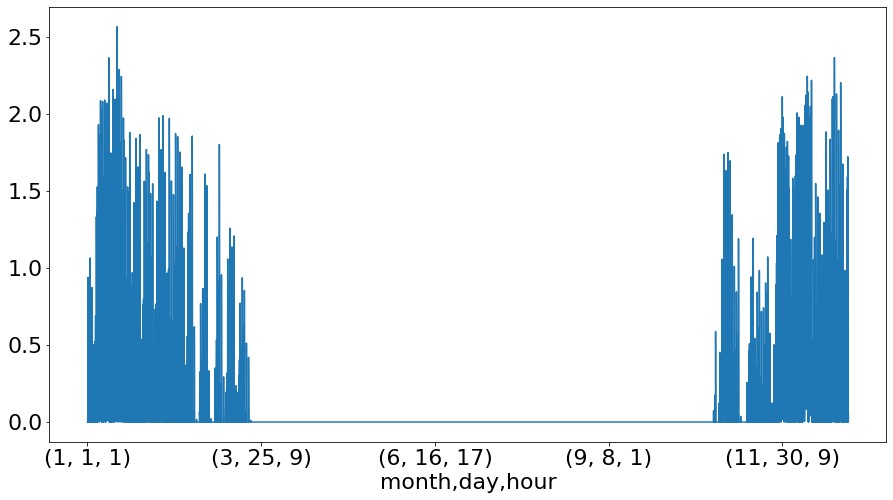

In [171]:
load_CH['Electricity for Space Heating [kWh]'].plot();

In [172]:
Total_elec_heating_CH = sum(load_CH['Electricity for Space Heating [kWh]'])

In [173]:
Total_elec_heating_CH

1034.6743396814395

In [174]:
HDD_Spain['Date'] = pd.to_datetime(HDD_Spain['Date'], format='%d-%m-%y')

In [175]:
HDD_Spain = HDD_Spain[~((HDD_Spain.Date.dt.month == 2) & (HDD_Spain.Date.dt.day == 29))]

In [176]:
HDD_Spain_averaged = HDD_Spain.groupby([HDD_Spain["Date"].dt.month, HDD_Spain["Date"].dt.day, HDD_Spain["Date"].dt.hour]).mean()

In [177]:
HDD_Spain_averaged.index.names = ["month", "day", "hour"]

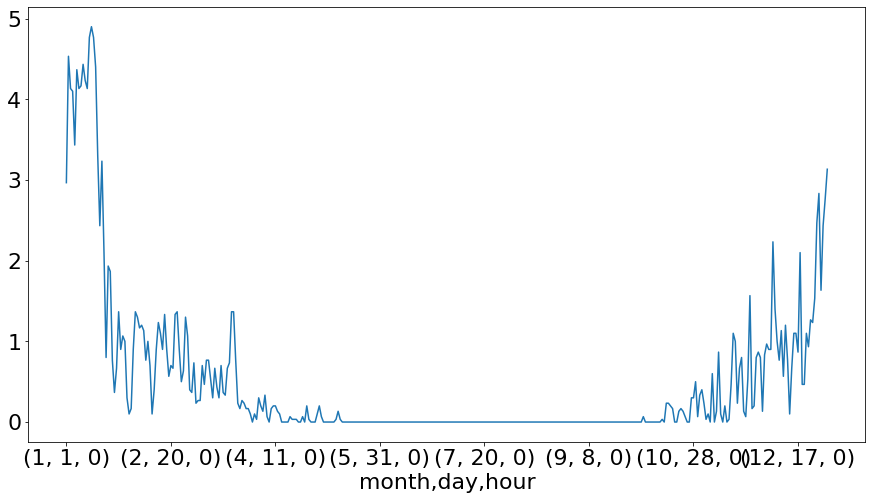

In [178]:
HDD_Spain_averaged['HDD 12'].plot();

In [179]:
HDD_CH['Date'] = pd.to_datetime(HDD_CH['Date'], format='%d-%m-%y')

In [180]:
HDD_CH = HDD_CH[~((HDD_CH.Date.dt.month == 2) & (HDD_CH.Date.dt.day == 29))]

In [181]:
HDD_CH_averaged = HDD_CH.groupby([HDD_CH["Date"].dt.month, HDD_CH["Date"].dt.day, HDD_CH["Date"].dt.hour]).mean()

In [182]:
HDD_CH_averaged.index.names = ["month", "day", "hour"]

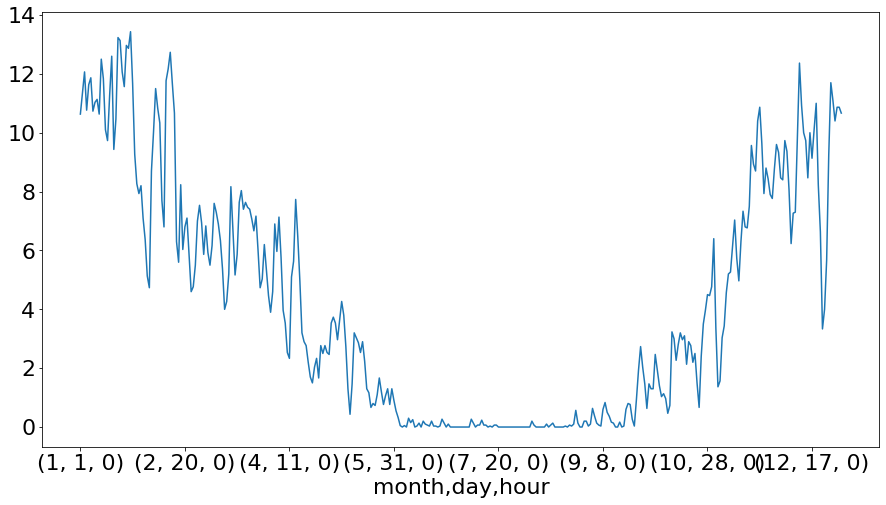

In [183]:
HDD_CH_averaged['HDD 12'].plot();

In [184]:
Total_HDD_CH = sum(HDD_CH_averaged['HDD 12'])
Total_HDD_CH

1523.0083333333332

In [185]:
Total_HDD_Spain = sum(HDD_Spain_averaged['HDD 12'])
Total_HDD_Spain

185.13333333333316

Reproduce a hourly profile for new locations based on climate pattern averaging Switzerland's daily profile

In [186]:
load_CH.index.get_level_values('hour')

Int64Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10,
            ...
            15, 16, 17, 18, 19, 20, 21, 22, 23,  0],
           dtype='int64', name='hour', length=8760)

In [187]:
heating_hourly_averaged_CH = load_CH['Electricity for Space Heating [kWh]'].groupby(load_CH.index.get_level_values('hour')).mean()

In [188]:
heating_hourly_normalized_CH = heating_hourly_averaged_CH/sum(heating_hourly_averaged_CH)

In [189]:
heating_hourly_normalized_CH

hour
0     0.002656
1     0.004483
2     0.006563
3     0.009003
4     0.011640
5     0.014603
6     0.016805
7     0.179140
8     0.148822
9     0.003278
10    0.005647
11    0.004871
12    0.004658
13    0.096371
14    0.063305
15    0.000150
16    0.001014
17    0.001871
18    0.092708
19    0.075385
20    0.069986
21    0.088585
22    0.097997
23    0.000458
Name: Electricity for Space Heating [kWh], dtype: float64

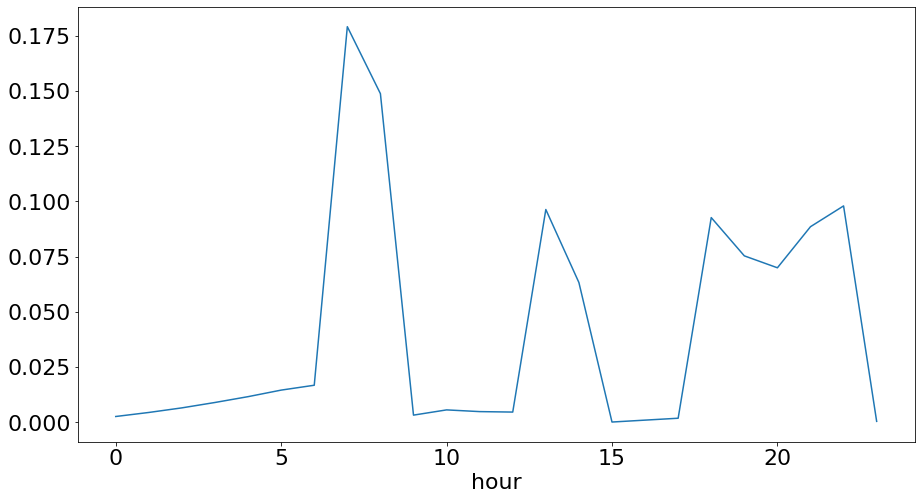

In [190]:
heating_hourly_normalized_CH.plot();

In [191]:
load_Spain = load_CH.copy()

In [192]:
ratio_CH = Total_elec_heating_CH/Total_HDD_CH
ratio_CH # kWh/HDD

0.679362231339141

In [193]:
HDD_Spain_averaged['HDD 12'].repeat(24)

month  day  hour
1      1    0       2.966667
            0       2.966667
            0       2.966667
            0       2.966667
            0       2.966667
                      ...   
12     31   0       3.133333
            0       3.133333
            0       3.133333
            0       3.133333
            0       3.133333
Name: HDD 12, Length: 8760, dtype: float64

In [194]:
heating_hourly_normalized_CH_df = np.tile(heating_hourly_normalized_CH, 365)
len(heating_hourly_normalized_CH_df)

8760

In [195]:
load_Spain['Electricity for Space Heating [kWh]'] = HDD_Spain_averaged['HDD 12'].repeat(24).values * heating_hourly_normalized_CH_df * ratio_CH

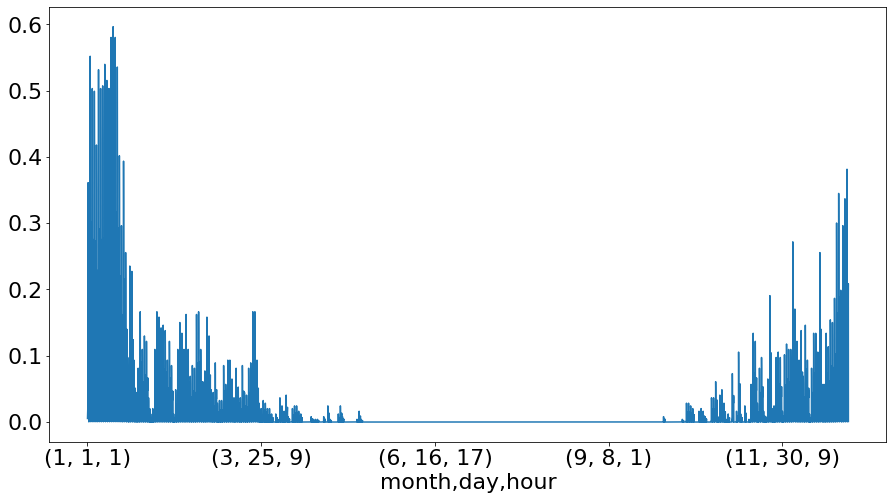

In [196]:
load_Spain['Electricity for Space Heating [kWh]'].plot();

In [197]:
sum(load_Spain['Electricity for Space Heating [kWh]'])

125.77259442858605

In [198]:
crosscheck = Total_elec_heating_CH*Total_HDD_Spain/Total_HDD_CH
crosscheck

125.77259442858617

## Now, let's analyze cooling demand

In [199]:
CDD_CH = pd.read_csv('Data/LSZH_CDD_22C+-3C.csv')

For Spain, LEZL station near Sevilla was selected

In [200]:
CDD_Spain = pd.read_csv('Data/LEZL_CDD_22C+-3C.csv')

Reproduce a hourly profile for new locations based on climate pattern averaging Switzerland's daily profile

In [201]:
Total_elec_cooling_CH = sum(load_CH['Electricity for Space Cooling [kWh]'])

In [202]:
Total_elec_cooling_CH

1144.119406827451

In [203]:
CDD_Spain['Date'] = pd.to_datetime(CDD_Spain['Date'], format='%d-%m-%y')

In [204]:
CDD_Spain = CDD_Spain[~((CDD_Spain.Date.dt.month == 2) & (CDD_Spain.Date.dt.day == 29))]

In [205]:
CDD_Spain_averaged = CDD_Spain.groupby([CDD_Spain["Date"].dt.month, CDD_Spain["Date"].dt.day, CDD_Spain["Date"].dt.hour]).mean()

In [206]:
CDD_Spain_averaged.index.names = ["month", "day", "hour"]

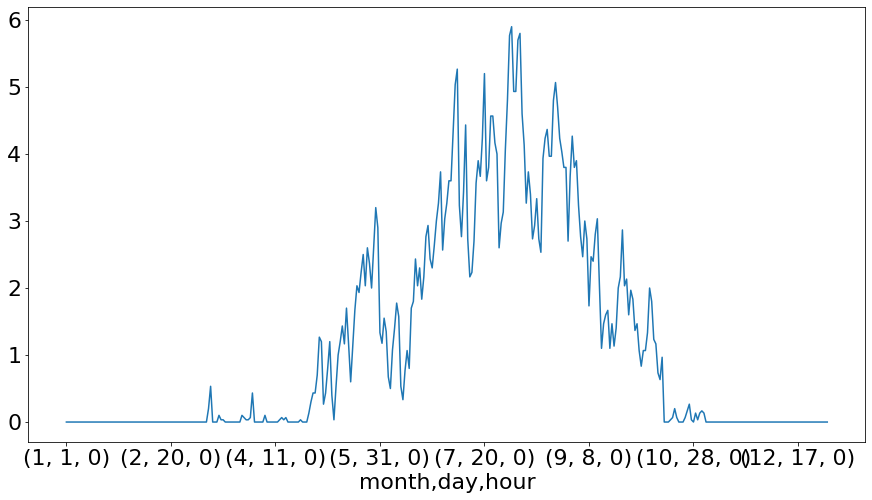

In [207]:
CDD_Spain_averaged['CDD 25'].plot();

In [208]:
CDD_CH['Date'] = pd.to_datetime(CDD_CH['Date'], format='%d-%m-%y')

In [209]:
CDD_CH = CDD_CH[~((CDD_CH.Date.dt.month == 2) & (CDD_CH.Date.dt.day == 29))]

In [210]:
CDD_CH_averaged = CDD_CH.groupby([CDD_CH["Date"].dt.month, CDD_CH["Date"].dt.day, CDD_CH["Date"].dt.hour]).mean()

In [211]:
CDD_CH_averaged.index.names = ["month", "day", "hour"]

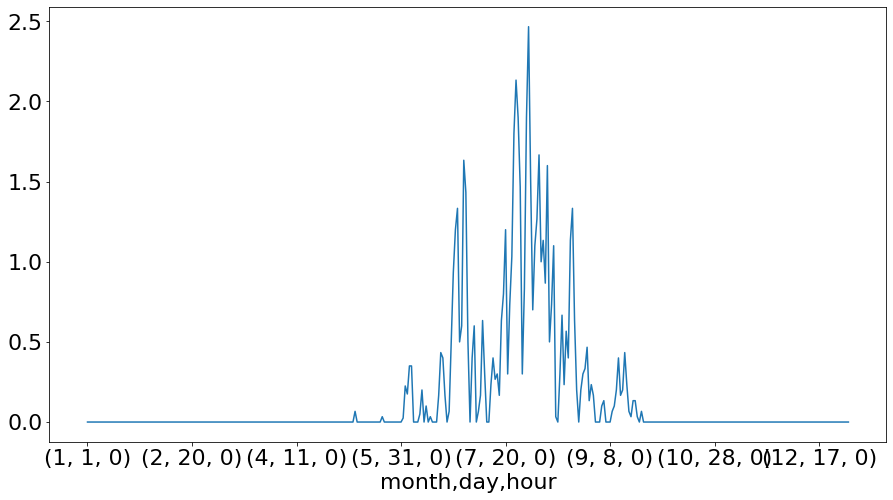

In [212]:
CDD_CH_averaged['CDD 25'].plot();

In [213]:
Total_CDD_CH = sum(CDD_CH_averaged['CDD 25'])
Total_CDD_CH

55.50833333333335

In [214]:
Total_CDD_Spain = sum(CDD_Spain_averaged['CDD 25'])
Total_CDD_Spain

428.1416666666667

In [215]:
cooling_hourly_averaged_CH = load_CH['Electricity for Space Cooling [kWh]'].groupby(load_CH.index.get_level_values('hour')).mean()

In [216]:
cooling_hourly_normalized_CH = cooling_hourly_averaged_CH/sum(cooling_hourly_averaged_CH)

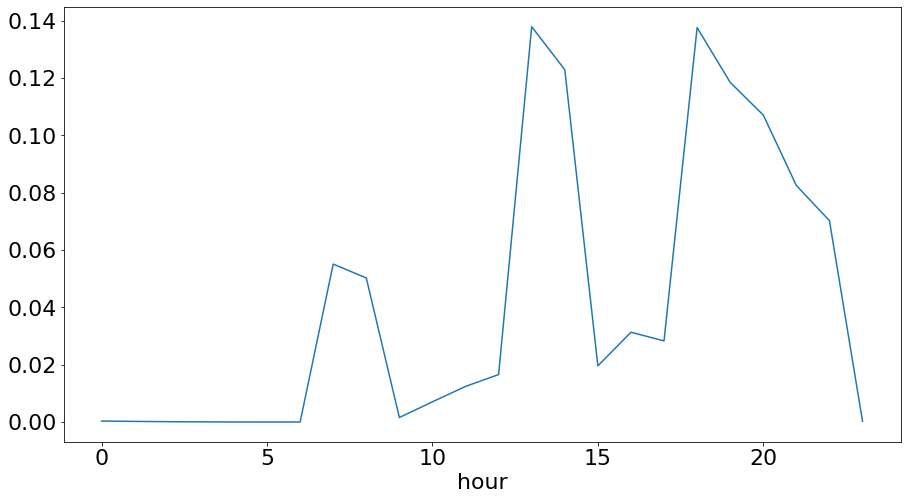

In [217]:
cooling_hourly_normalized_CH.plot();

In [218]:
ratio_CH = Total_elec_cooling_CH/Total_CDD_CH
ratio_CH # kWh/HDD

20.6116692417496

In [219]:
cooling_hourly_normalized_CH_df = np.tile(cooling_hourly_normalized_CH, 365)
len(cooling_hourly_normalized_CH_df)

8760

In [220]:
load_Spain['Electricity for Space Cooling [kWh]'] = CDD_Spain_averaged['CDD 25'].repeat(24).values * cooling_hourly_normalized_CH_df * ratio_CH

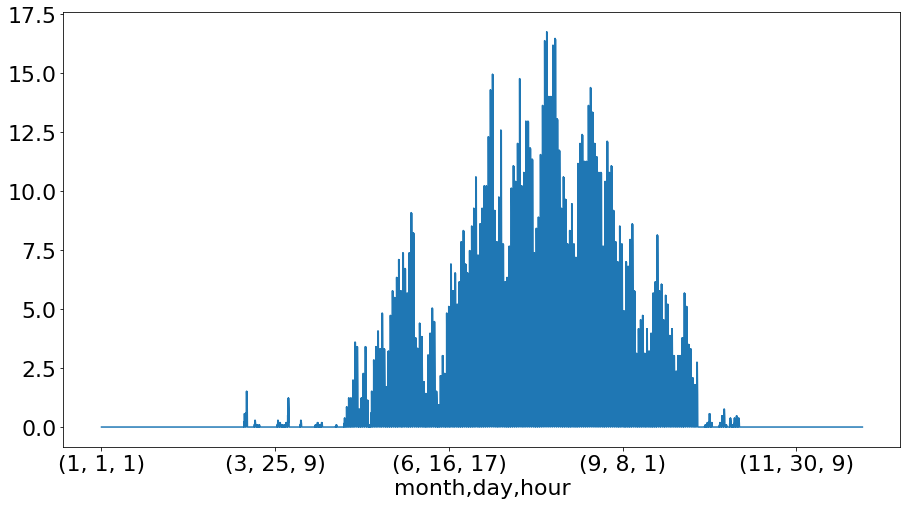

In [221]:
load_Spain['Electricity for Space Cooling [kWh]'].plot();

In [222]:
sum(load_Spain['Electricity for Space Cooling [kWh]'])

8824.714421944747

In [223]:
crosscheck = Total_elec_cooling_CH*Total_CDD_Spain/Total_CDD_CH
crosscheck

8824.714421944744

In [224]:
load_Spain['Total Electricity'] = load_Spain['Electricity demand [kWh](Hourly) '] + load_Spain['Electricity for Space Heating [kWh]'] + load_Spain['Electricity for Hot Water [kWh]'] + load_Spain['Electricity for Space Cooling [kWh]']

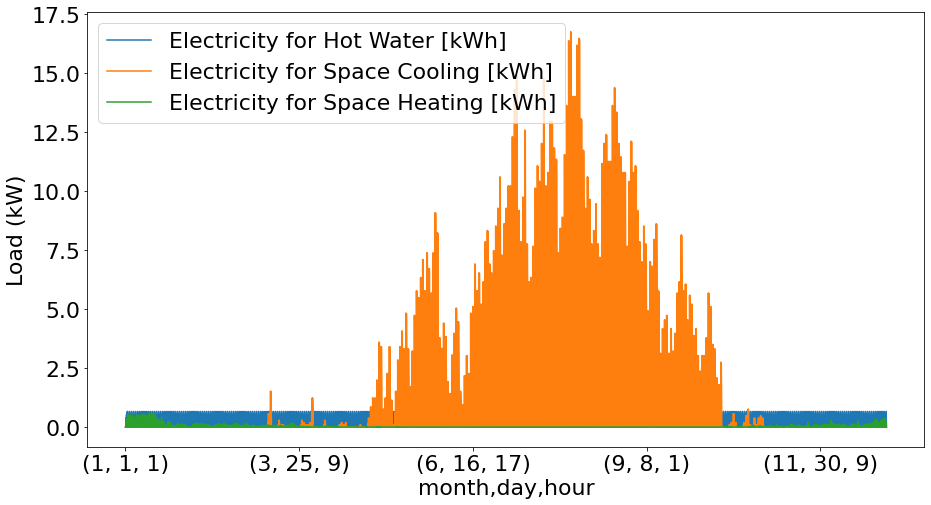

In [225]:
load_Spain[['Electricity for Hot Water [kWh]', 'Electricity for Space Cooling [kWh]', 'Electricity for Space Heating [kWh]']].plot(ylabel = 'Load (kW)');

In [226]:
load_Spain['Total Electricity without AC'].to_pickle('Calculations/Spain/load_Spain_modern_full_retrofit_no_AC.pkl')

In [227]:
load_Spain['Total Electricity'].to_pickle('Calculations/Spain/load_Spain_modern_full_retrofit.pkl')